In [1]:
%load_ext autoreload
%autoreload 2

# import fsspec
# import h5py
# from rasterio.session import AWSSession
# import rasterio as rio

import xarray as xr
from matplotlib import cm
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from carbonplan_styles.mpl import set_theme
set_theme()
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import seaborn as sns
import pandas as pd
# from carbonplan_trace.v1 import utils
# from carbonplan_trace.v0.data import cat
# import boto3
# import numpy as np
# import pandas as pd
# from collections import defaultdict
# from datetime import datetime 
# import dask
# from carbonplan_trace.v1.landsat_preprocess import access_credentials

In [2]:
# import fsspec
# import numpy as np
# import pandas as pd
# import xarray as xr
# from carbonplan.data import cat
# import cartopy.crs as ccrs
# import matplotlib.pyplot as plt
# import warnings
# warnings.filterwarnings('ignore')
# import matplotlib
# from carbonplan_data import utils
# from matplotlib import cm
# import rioxarray

# from carbonplan_trace.v1 import glas_allometric_eq as allo

# import os

# matplotlib.rc('font', family='sans-serif') 
# matplotlib.rc('font', serif='Helvetica Neue') 
# matplotlib.rc('text', usetex='false') 
# matplotlib.rcParams.update({'font.size': 14, "svg.fonttype": "none"})

# from gcsfs import GCSFileSystem
# fs = GCSFileSystem(cache_timeout=0)

# from carbonplan_styles.mpl import set_theme
# set_theme()

# Get comparison data 

In [3]:
version = 'v1.2'


In [3]:

ds = xr.open_zarr(f"s3://carbonplan-climatetrace/{version}/results/global/3000m/raster_biomass.zarr")
# average carbonplan data for comparison since all other datasets are ~snapshots 
ds = ds.mean(dim='time').compute()
# rename
ds = ds[['AGB']].rename({'AGB': 'CarbonPlan'})
ds = ds.assign_coords({'lat': ds.lat.round(4), 'lon': ds.lon.round(4)})

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [4]:
comps = ['Harris', 'Spawn', 'GEDI']
for name in comps:
    temp = xr.open_zarr(f"s3://carbonplan-climatetrace/validation/{name.lower()}_3000m_agbd.zarr")
    temp = temp.assign_coords({'lat': ds.lat, 'lon': ds.lon})
    ds[name] = temp['agbd']

In [5]:
# also load realm 
realms = xr.open_zarr('s3://carbonplan-climatetrace/validation/realm_mask.zarr')
realms = realms.assign_coords({'lat': realms.lat.round(4), 'lon': realms.lon.round(4)})
ds['realm'] = realms.realm

In [6]:
ds

<xarray.Dataset>
Dimensions:     (lat: 5600, lon: 14400)
Coordinates:
  * lat         (lat) float64 -59.99 -59.96 -59.94 -59.91 ... 79.94 79.96 79.99
  * lon         (lon) float64 -180.0 -180.0 -179.9 -179.9 ... 179.9 180.0 180.0
Data variables:
    CarbonPlan  (lat, lon) float64 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    Harris      (lat, lon) float64 dask.array<chunksize=(400, 400), meta=np.ndarray>
    Spawn       (lat, lon) float64 dask.array<chunksize=(350, 900), meta=np.ndarray>
    GEDI        (lat, lon) float32 dask.array<chunksize=(350, 900), meta=np.ndarray>
    realm       (lat, lon) <U13 dask.array<chunksize=(175, 450), meta=np.ndarray>

In [7]:
# mask to land only
land_mask = xr.open_zarr('s3://carbonplan-climatetrace/validation/land_mask.zarr')
land_mask = land_mask.assign_coords({'lat': land_mask.lat.round(4), 'lon': land_mask.lon.round(4)})
ds = ds.where(land_mask.land_mask == 0)

# Maps


In [8]:
from cartopy.io import shapereader
import geopandas as gpd

def cartopy_proj_plate_carree():
    return ccrs.PlateCarree()


def cartopy_borders_global():
    states_df = gpd.read_file(
        shapereader.natural_earth("50m", "cultural", "admin_1_states_provinces")
    )
    states = states_df.set_crs(epsg=4326).to_crs(epsg=32662)["geometry"].values

    countries_df = gpd.read_file(
        shapereader.natural_earth("50m", "cultural", "admin_0_countries")
    )
    countries = (
        countries_df.set_crs(epsg=4326).to_crs(epsg=32662)["geometry"].values
    )

    return states, countries

In [9]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable


def map_pretty(
    ax, title="", min_lat=-90, max_lat=90, min_lon=-180, max_lon=180
):
    state_borders, country_borders = cartopy_borders_global()

    ax.add_geometries(
        state_borders,
        facecolor="none",
        edgecolor="k",
        crs=cartopy_proj_plate_carree(),
        linewidth=0.1,
        zorder=0,
    )
    ax.add_geometries(
        country_borders,
        facecolor="none",
        edgecolor="k",
        crs=cartopy_proj_plate_carree(),
        linewidth=0.3,
        zorder=0,
    )
    ax.axis("off")
    ax.set_extent([min_lon, max_lon, min_lat, max_lat])
    ax.text(0.35, 1.05, title, transform=ax.transAxes)


def add_colorbar(
    fig,
    to_plot=None,
    x_location=1.08,
    y_location=0.76,
    height=0.12,
    width=0.018,
    vmin=None,
    vmax=None,
    cbar_label="",
    cmap="viridis",
):

    cax = fig.add_axes([x_location, y_location, width, height])
    cax.text(
        0.5,
        -0.08,
        vmin,
        transform=cax.transAxes,
        horizontalalignment="center",
        verticalalignment="center",
    )
    cax.text(
        0.5,
        1.08,
        vmax,
        transform=cax.transAxes,
        horizontalalignment="center",
        verticalalignment="center",
    )
    cax.text(
        1.8,
        0.5,
        cbar_label,
        transform=cax.transAxes,
        verticalalignment="center",
        multialignment="center",
        rotation=-90,
    )
    if to_plot is not None:
        cbar = fig.colorbar(to_plot, cax=cax, orientation="vertical")
    else:
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        cbar = fig.colorbar(
            mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
            cax=cax,
            orientation="vertical",
        )
    cbar.outline.set_visible(False)
    cbar.set_ticks([])
    return cbar

In [10]:
def plot_map(data, names, titles, plot_params):
    vmin, vmax = plot_params["var_lims"][0], plot_params["var_lims"][1]

    plt.figure(figsize=(20, 10))
    for i, name in enumerate(names):
        if name is None:
            continue
        da = data[name]
        plt.subplot(nrows, ncols, i + 1, projection=cartopy_proj_plate_carree())
        ax = plt.gca()

        map_plot = da.plot.imshow(
            ax=ax,
            cmap=plot_params["cmap"],
            vmin=vmin,
            vmax=vmax,
            add_colorbar=False,
            transform=ccrs.PlateCarree(),
        )

        map_pretty(
            ax,
            title=titles[i],
        )

    fig = plt.gcf()
    cax = fig.add_axes([1.05, 0.33, 0.03, 0.35])
    cbar = fig.colorbar(map_plot, cax=cax, orientation="vertical")
    cax.text(
        0.5,
        -0.12,
        plot_params["var_lims"][0],
        transform=cax.transAxes,
        horizontalalignment="center",
    )
    cax.text(
        0.5,
        1.05,
        plot_params["var_lims"][1],
        transform=cax.transAxes,
        horizontalalignment="center",
    )
    cax.text(
        1.8,
        0.5,
        plot_params["label"],
        transform=cax.transAxes,
        verticalalignment="center",
        multialignment="center",
        rotation=-90,
    )
    cbar.outline.set_visible(False)
    cbar.set_ticks([])
    plt.tight_layout()
    plt.show()
    plt.close()

/tmp/ipykernel_3154/3886859966.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


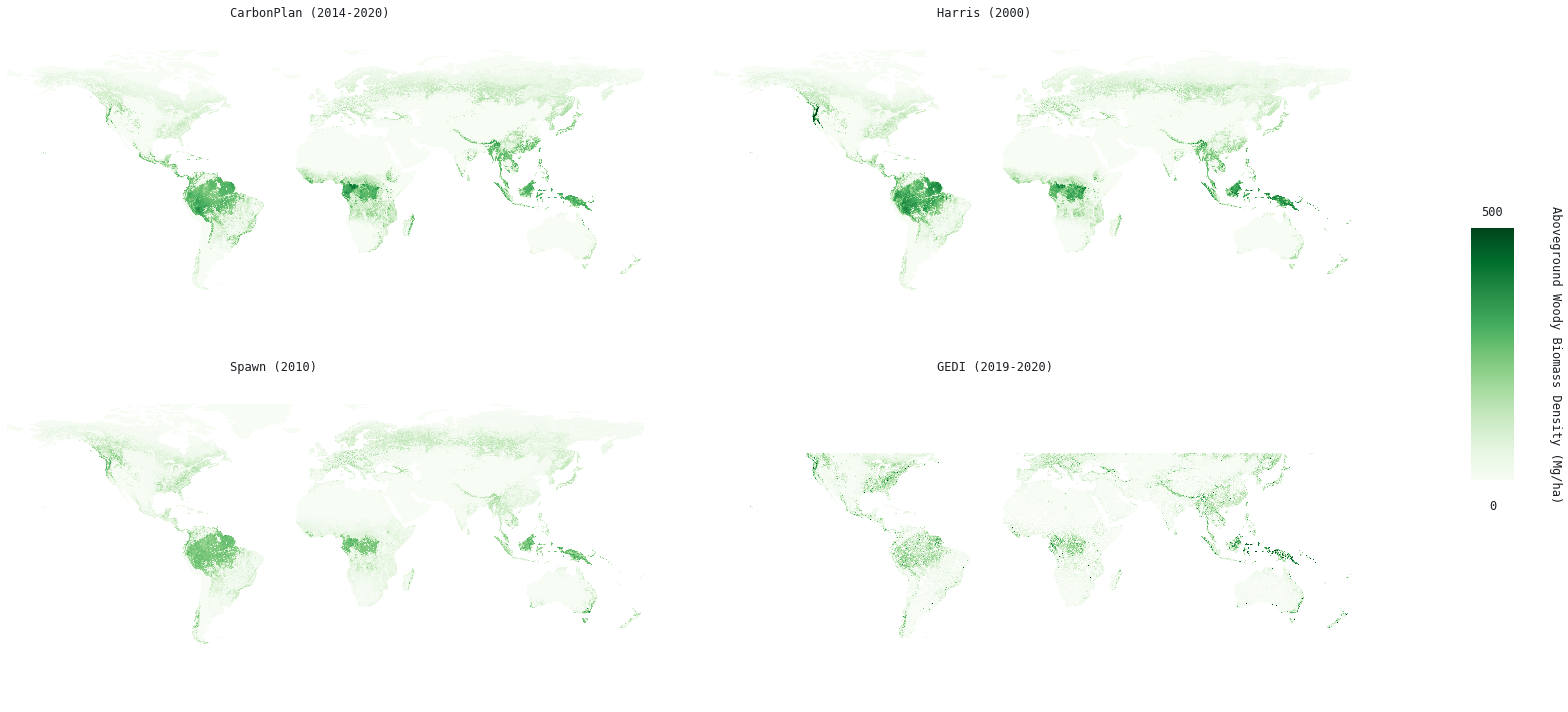

In [11]:
nrows = 2
ncols = 2
names = ['CarbonPlan'] + comps
titles = [
    "CarbonPlan (2014-2020)",
    "Harris (2000)",
    "Spawn (2010)",
    "GEDI (2019-2020)",
]
plot_params = {
    "cmap": cm.Greens,
    "var_lims": (0, 500),
    "label": "Aboveground Woody Biomass Density (Mg/ha)",
}

plot_map(data=ds, names=names, titles=titles, plot_params=plot_params)

In [12]:
abs_diff = xr.Dataset()
for name in comps:
    abs_diff[name] = ds['CarbonPlan'] - ds[name]

/tmp/ipykernel_3154/3886859966.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


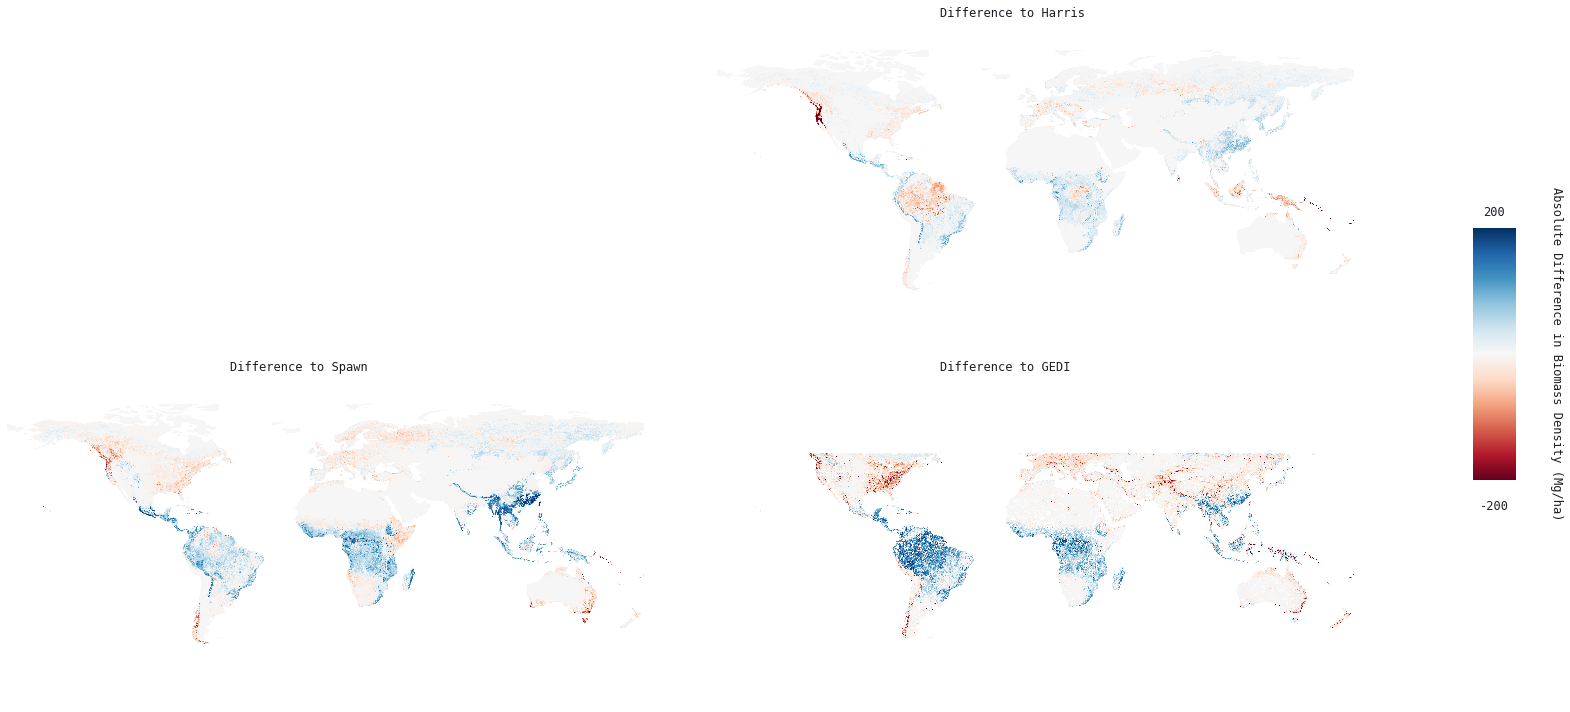

In [13]:
nrows = 2
ncols = 2
names = [None] + comps
titles = [
    None,
    "Difference to Harris",
    "Difference to Spawn",
    "Difference to GEDI",
]
plot_params = {
    "cmap": cm.RdBu,
    "var_lims": (-200, 200),
    "label": "Absolute Difference in Biomass Density (Mg/ha)",
}

plot_map(data=abs_diff, names=names, titles=titles, plot_params=plot_params)

In [14]:
pct_diff = xr.Dataset()
for name in comps:
    pct_diff[name] = 100. * (ds['CarbonPlan'] - ds[name]) / ds[name]

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/tmp/ipykernel_3154/3886859966.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


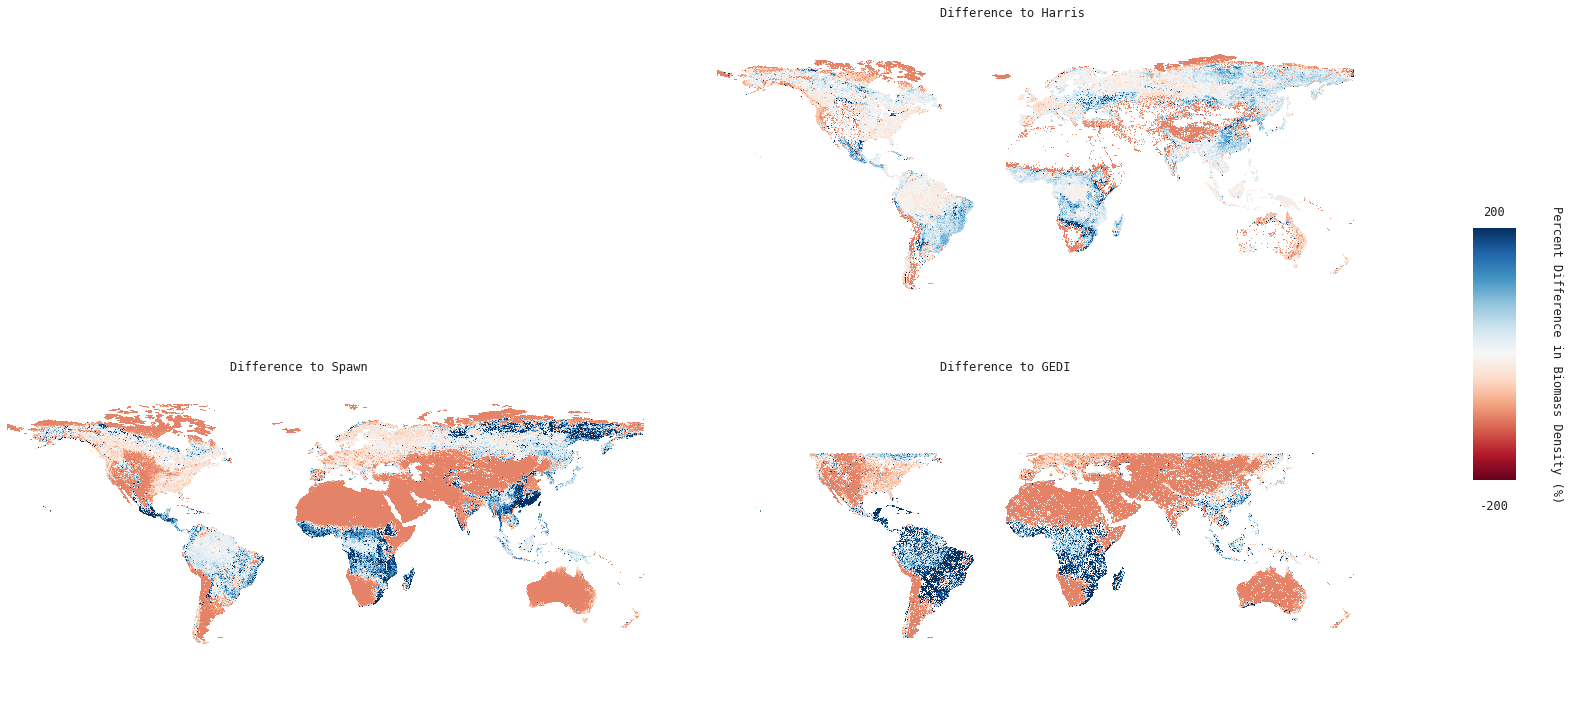

In [15]:
nrows = 2
ncols = 2
names = [None] + comps
titles = [
    None,
    "Difference to Harris",
    "Difference to Spawn",
    "Difference to GEDI",
]
plot_params = {
    "cmap": cm.RdBu,
    "var_lims": (-200, 200),
    "label": "Percent Difference in Biomass Density (%)",
}

plot_map(data=pct_diff, names=names, titles=titles, plot_params=plot_params)

# Scatter plots

In [16]:
df = ds.to_dataframe()
df['realm'] = df.realm.replace(['nan', 'ice'], np.nan)

In [62]:
def subplot_hist(
    ax,
    x_col,
    y_col,
    x_name,
    y_name,
    plot_params,
#     c="b",
#     s=0.002,
#     alpha=0.1,
):
#     tot = np.hstack((x_col, y_col))
#     xmax = np.percentile(tot, 99.5)
    xmin = plot_params["xmin"]
    xmax = plot_params["xmax"]
    unit = plot_params["unit"]

    ax.plot([xmin, xmax], [xmin, xmax], "0.5")
    bias = np.mean(ycol - xcol)
    r2 = r2_score(x_col, y_col)
    mae = mean_absolute_error(x_col, y_col)
    
#     ax.scatter(x_col, y_col, c=c, s=s, alpha=alpha, marker="o")
    ind = (xcol < xmax) & (ycol < xmax)
    sns.histplot(ax=ax, x=xcol[ind], y=ycol[ind], bins=100, pthresh=0.01, pmax=0.3)
    ax.text(plot_params["text_x"], xmax * 0.9, f"bias = {round(bias, 2)} {unit}")
    ax.text(plot_params["text_x"], xmax * 0.81, f"MAE = {round(mae, 2)} {unit}")
    ax.text(plot_params["text_x"], xmax * 0.72, f"R$^2$ = {round(r2, 2)}")
    if unit != "":
        unit_str = f"({unit})"
    else:
        unit_str = ""
    ax.set_xlabel(f"Biomass from {x_name} {unit_str}")
    ax.set_ylabel(f"Biomass from {y_name} {unit_str}")
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(xmin, xmax)
    ticks = np.arange(0, xmax, 100)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)

In [29]:
plot_params = {
    "xmin": -10,
    "xmax": 510,
    "unit": "Mg/ha",
    "text_x": 10,
#     "text_y1": 450,
#     "text_y2": 420,
#     "text_y3": 390,
#     "ticks": np.arange(0, 510, 100),
}

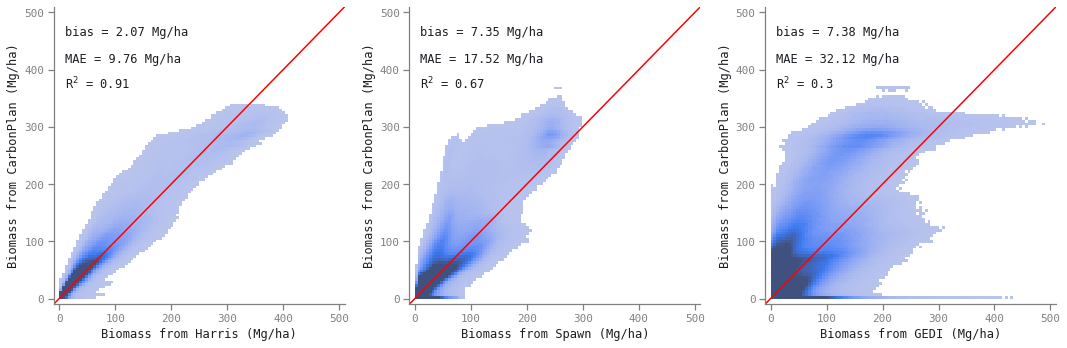

In [30]:
fig, axarr = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for i, name in enumerate(comps):
    sub = df[['CarbonPlan', name]].dropna(how='any')
    ycol = sub['CarbonPlan'].values
    xcol = sub[name].values
    subplot_hist(
        ax=axarr[i],
        x_col=xcol,
        y_col=ycol,
        x_name=name,
        y_name="CarbonPlan",
        plot_params=plot_params,
    )
plt.tight_layout()
plt.show()
plt.close()

In [59]:
realms = df.realm.dropna().unique()

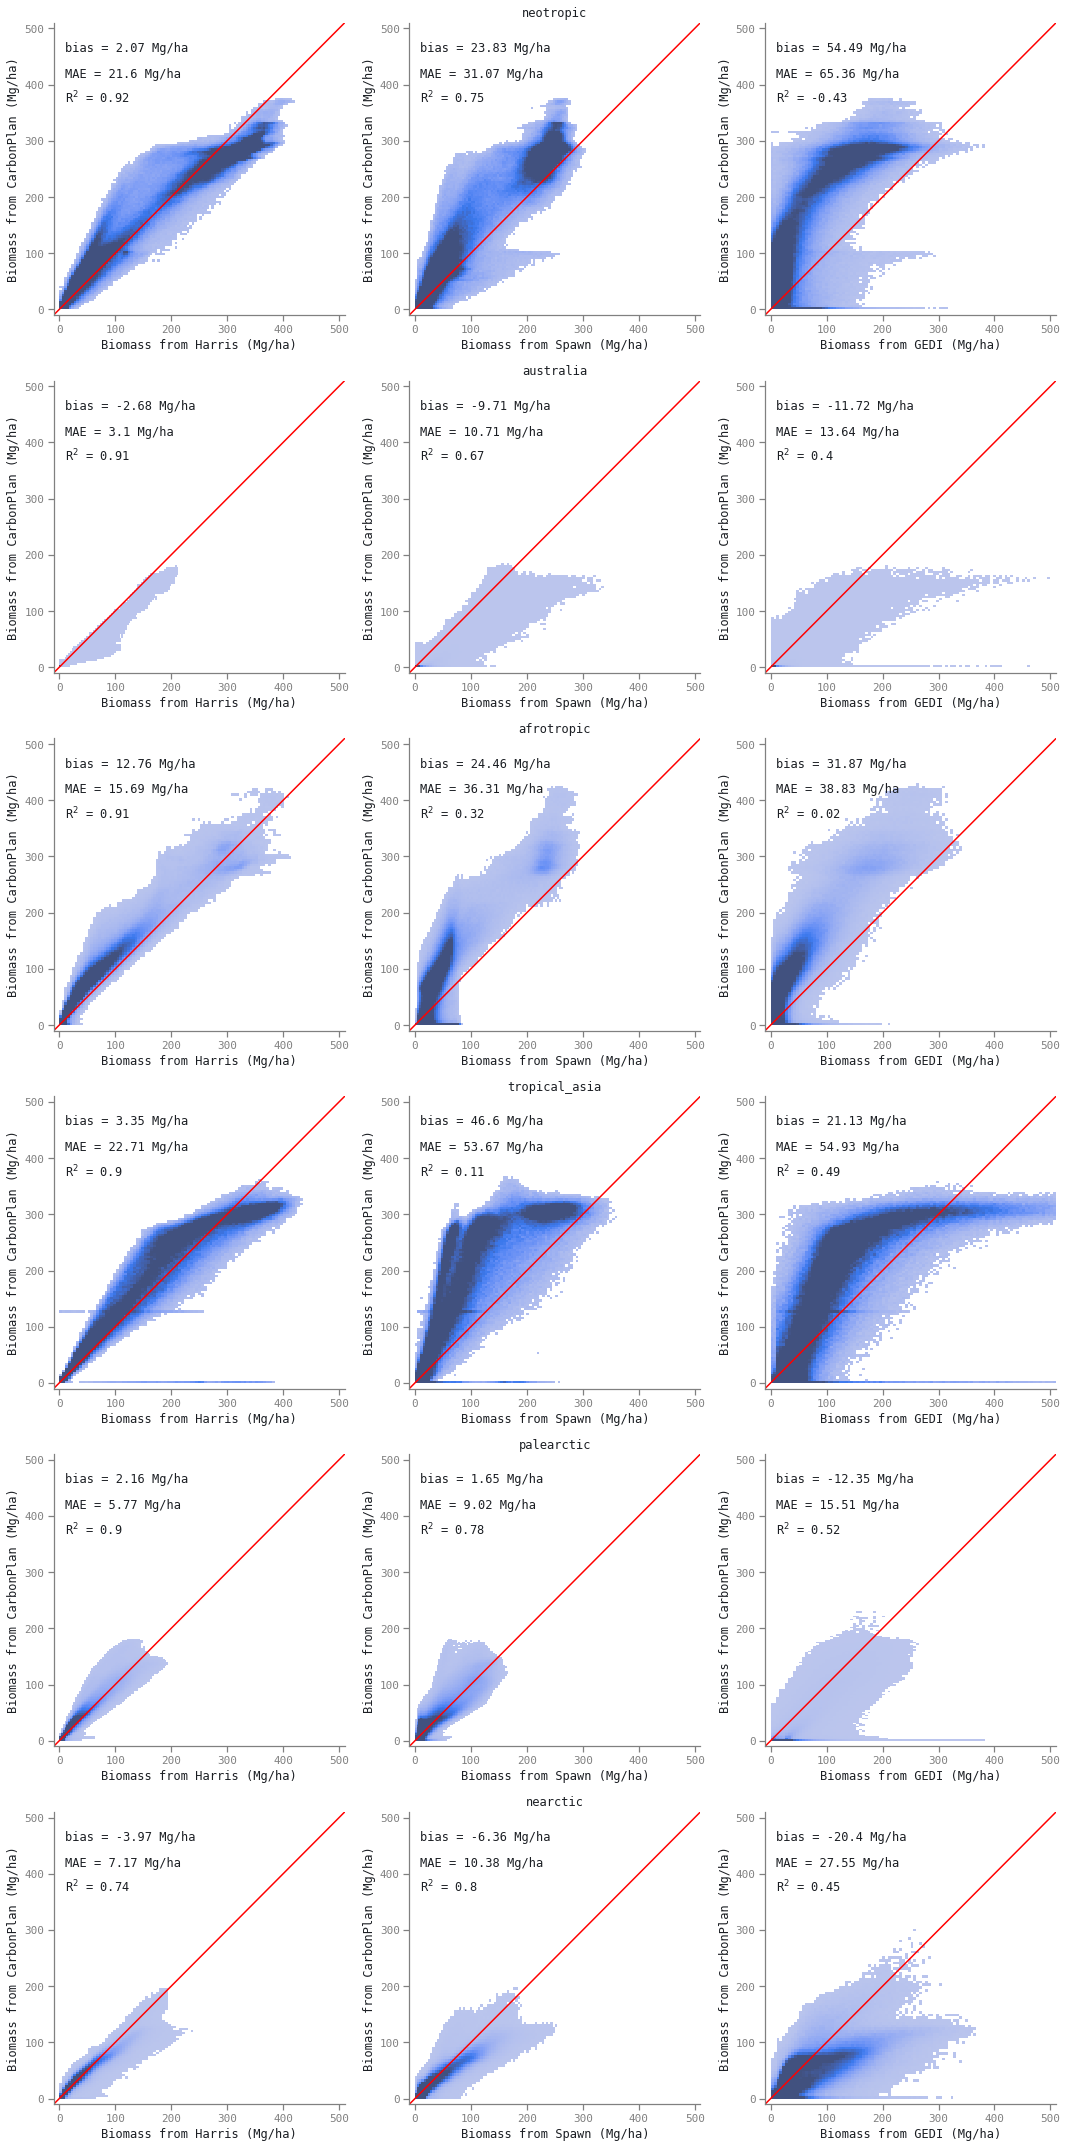

In [67]:
fig, axarr = plt.subplots(nrows=6, ncols=3, figsize=(15,30))
for i, realm in enumerate(realms):
    for j, name in enumerate(comps):
        sub = df.loc[df.realm == realm][['CarbonPlan', name]].dropna(how='any')
        ycol = sub['CarbonPlan'].values
        xcol = sub[name].values
        subplot_hist(
            ax=axarr[i, j],
            x_col=xcol,
            y_col=ycol,
            x_name=name,
            y_name="CarbonPlan",
            plot_params=plot_params,
        )
        if j == 1:
            axarr[i, j].set_title(realm)
plt.tight_layout()
plt.show()
plt.close()

In [53]:
def subplot_kde(
    ax,
    data,
    x_col_name,
    y_col_name,
    hue_name,
    x_name,
    y_name,
    plot_params,

):
    xmin = plot_params["xmin"]
    xmax = plot_params["xmax"]
    unit = plot_params["unit"]

    ax.plot([xmin, xmax], [xmin, xmax], "0.5")
    x_col = data[x_col_name].values
    y_col = data[y_col_name].values
    bias = np.mean(ycol - xcol)
    r2 = r2_score(x_col, y_col)
    mae = mean_absolute_error(x_col, y_col)
    
    sub = data.loc[(data[x_col_name] < xmax) & (data[y_col_name] < xmax)].sample(int(1e6))
    sns.kdeplot(data=sub, x=name, y='CarbonPlan', hue='realm', levels=7, linewidth=0.5, ax=ax)
    ax.text(plot_params["text_x"], xmax * 0.9, f"bias = {round(bias, 2)} {unit}")
    ax.text(plot_params["text_x"], xmax * 0.81, f"MAE = {round(mae, 2)} {unit}")
    ax.text(plot_params["text_x"], xmax * 0.72, f"R$^2$ = {round(r2, 2)}")
    if unit != "":
        unit_str = f"({unit})"
    else:
        unit_str = ""
    ax.set_xlabel(f"Biomass from {x_name} {unit_str}")
    ax.set_ylabel(f"Biomass from {y_name} {unit_str}")
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(xmin, xmax)
    ticks = np.arange(0, xmax, 100)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)

/srv/conda/envs/notebook/lib/python3.9/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/srv/conda/envs/notebook/lib/python3.9/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/srv/conda/envs/notebook/lib/python3.9/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


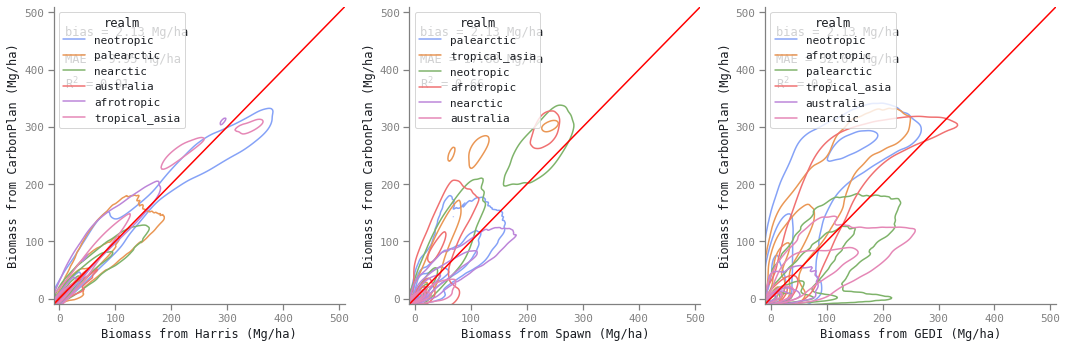

In [54]:
fig, axarr = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for i, name in enumerate(comps):
    sub = df[['CarbonPlan', name, 'realm']].dropna(how='any')

    subplot_kde(
        ax=axarr[i],
        data=sub,
        x_col_name=name,
        y_col_name='CarbonPlan',
        hue_name='realm',
        x_name=name,
        y_name="CarbonPlan",
        plot_params=plot_params,
    )
plt.tight_layout()
plt.show()
plt.close()

# country level comparisons

In [21]:
df = pd.read_csv(f's3://carbonplan-climatetrace/{version}/country_rollups_AGB.csv')
df = df.groupby('iso3_country').agbd.mean().reset_index()
df = df.rename(columns={'agbd': 'CarbonPlan'})

In [22]:
comps = ['Harris', 'Spawn', 'GEDI']
for name in comps:
    temp = pd.read_csv(f"s3://carbonplan-climatetrace/validation/{name.lower()}_country_rollups_agbd.csv")
    temp = temp.rename(columns={'agbd': name})
    df = df.merge(temp, on=['iso3_country'])

In [23]:
df.head()

,iso3_country,CarbonPlan,Harris,Spawn,GEDI
0,ABW,1.021245,1.060841,2.189218,3.434316
1,AFG,0.738528,0.855988,1.059667,23.863041
2,AGO,89.626021,63.206755,54.281637,32.015339
3,AIA,0.000000,19.433384,12.774334,1.788038
4,ALA,52.973730,44.449908,48.672792,0.000000


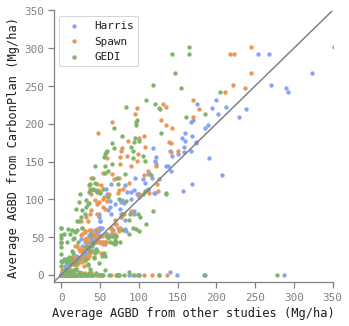

In [26]:
plt.figure(figsize=(5, 5))
for name in comps:
    plt.scatter(df[name].values, df.CarbonPlan.values, label=name, s=11)

xmin = -10
xmax = 350
plt.plot([xmin, xmax], [xmin, xmax], '0.5')
plt.legend()

plt.xlim(xmin, xmax)
plt.ylim(xmin, xmax)
plt.xlabel('Average AGBD from other studies (Mg/ha)')
plt.ylabel('Average AGBD from CarbonPlan (Mg/ha)')
plt.show()
plt.close()

In [27]:
df.loc[(df.CarbonPlan < 10) & (df.Harris > 50)]

,iso3_country,CarbonPlan,Harris,Spawn,GEDI
71,FJI,0.000000,185.708167,51.914279,126.381841
118,KNA,0.000000,100.778278,64.520645,23.896484
149,MSR,0.000000,87.676475,74.160086,61.135921
151,MUS,0.000000,100.005536,24.858342,38.802956
156,NCL,4.181442,139.779390,38.072139,86.864467
183,REU,0.000000,149.530633,24.328727,70.055288
194,SLB,0.000000,286.707641,136.231322,277.653127


In [28]:
df.loc[(df.CarbonPlan < 10) & (df.Spawn > 50)]

,iso3_country,CarbonPlan,Harris,Spawn,GEDI
10,ASM,0.000000,0.000000,116.511386,74.481228
71,FJI,0.000000,185.708167,51.914279,126.381841
75,FSM,0.000000,18.775710,95.096317,49.528454
118,KNA,0.000000,100.778278,64.520645,23.896484
146,MNP,0.000000,0.000000,72.104245,34.732974
149,MSR,0.000000,87.676475,74.160086,61.135921
194,SLB,0.000000,286.707641,136.231322,277.653127
219,TON,0.180639,0.000000,71.401936,34.660218
239,WSM,0.000000,0.000000,106.994380,125.590749
